In [2]:
# importing all the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space
import pandas as pd

import os
cwd = os.getcwd()

%run ../functions_MCMC

In [3]:
# define variables
data_seed = 1223
burnin = 10000 #10k
n_after_burnin = 10000 #10k
delta_t = 0.3

#T=60 gives 200 delta_y
T = 60
n_chains = 4
n_sim = 1

V_F = 2000
V_B = -1500
V = np.array([V_F, V_B])
Lambda = np.array([1, 0.5, 0.3])
log_Lambda = np.log(Lambda)
Pij = np.array([0.2, 0.3, 0.7])
sigma = 50.0
n_param = 9

parameter_names = ['v1', 'v2', 'log(lambda1)', 'log(lambda2)',
                   'log(lambda3)', 'p12', 'p21', 'p31', 'sigma']
parameter_names_tex = [r'$v_1$', r'$v_2$', r'log$(\lambda_1)$',
                       r'log$(\lambda_2)$', r'log$(\lambda_3)$', r'$p_{12}$', r'$p_{21}$', r'$p_{31}$',
                       r'$\sigma$']

#choose initial covariance matrix for resampling
init_cov_matrix = np.array([np.diag(np.array([0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]))
                            for _ in range(n_chains)])


correlated = True
up_to_switches = 1
track = True

plots = False
save = True
all_plots = False
plot_posteriors_grid = False
plot_fit = False
plot_fit_median = False

theta_true = list(V) + list(log_Lambda) + list(Pij) + [sigma] #not including values for P for 2x2

In [4]:
theta_all = {'120_1st':[], '120_2nd':[], '120_3rd':[], '120_4th':[], '120_4':[]}
log_pi = {'120_1st':[], '120_2nd':[], '120_3rd':[], '120_4th':[], '120_4':[]}
theta_best = {'120_1st':[], '120_2nd':[], '120_3rd':[], '120_4th':[], '120_4':[]}

In [5]:
#importing the inference results for the 4 tracks separately
#the results can be generated running the jupiter notebook in each folder
el1 = '120'
for el2 in ['1st', '2nd', '3rd', '4th']:
    el = el1+'_'+el2
    for param in parameter_names:
        theta_all[el] += [np.array(pd.read_csv("T="+el1+" - "+el2+
                                               " track/MCMC, parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
    theta_all[el] = np.array(theta_all[el])

    log_pi[el] = np.array(pd.read_csv("T="+el1+" - "+el2+
                                      " track/MCMC, log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()
    theta_best[el] = theta_all[el][:, np.argmax(log_pi[el])]

In [6]:
#importing the inference results for the 4 tracks used together
#the results can be generated running the jupiter notebook in the folder 
#"T=120 - n_tracks=4"
el1 = '120'
for el2 in ['4']:
    el = el1+'_'+el2
    for param in parameter_names:
        theta_all[el] += [np.array(pd.read_csv("T=120 - n_tracks=4/MCMC, parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
    theta_all[el] = np.array(theta_all[el])

    log_pi[el] = np.array(pd.read_csv("T=120 - n_tracks=4/MCMC, log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()
    theta_best[el] = theta_all[el][:, np.argmax(log_pi[el])]

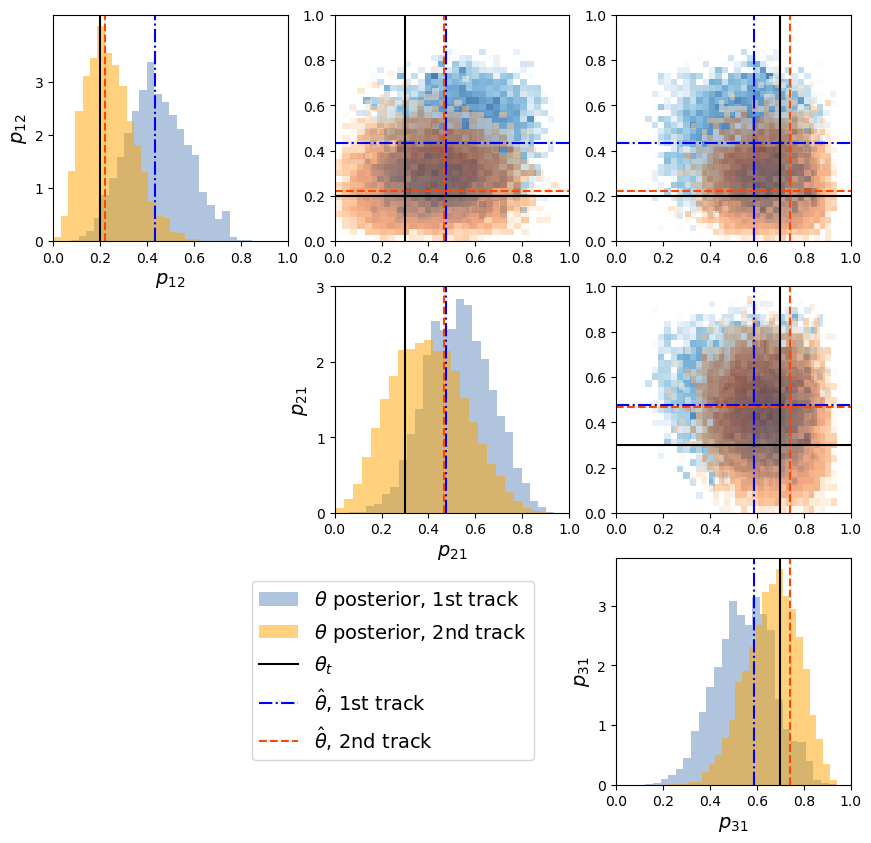

In [7]:
#Figure 4 panel A
fig, ax = plt.subplots(3, 3, figsize=(3*2+5,3*2+4))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(3):
    ax[i,i].set_ylabel(parameter_names_tex[i+5], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i+5], fontsize=14)
    
priors = [[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0], [-4.0, 4.0],
          [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 2.0*sigma]]

for i in range(3):
    ax[i,i].hist(theta_all['120_1st'][i+5,:], bins=25, alpha=1.0, density=True,
                 label=r'$\theta$ posterior, 1st track', color='lightsteelblue')
    ax[i,i].hist(theta_all['120_2nd'][i+5,:], bins=25, alpha=0.5, density=True,
                 label=r'$\theta$ posterior, 2nd track', color='orange')
    if theta_true is not None:
        ax[i,i].axvline(theta_true[i+5], color='black',
                        label=r'$\theta_t$')
    if log_pi is not None:
        best_theta_comp_i = {}
        best_theta_comp_i['120_1st'] = theta_all['120_1st'][i+5, np.nanargmax(log_pi['120_1st'])]
        ax[i,i].axvline(best_theta_comp_i['120_1st'], linestyle='-.', color='blue',
                        label=r'$\hat\theta$, 1st track')
        best_theta_comp_i['120_2nd'] = theta_all['120_2nd'][i+5, np.nanargmax(log_pi['120_2nd'])]
        ax[i,i].axvline(best_theta_comp_i['120_2nd'], linestyle='--', color='orangered',
                        label=r'$\hat\theta$, 2nd track')
    ax[i,i].set_xlim(priors[i+5])
    ax[i,i].set_yticks([0,1,2,3])
for i in range(3):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,3):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all['120_1st'][j+5,:], theta_all['120_1st'][i+5,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='Blues')
        ax[i,j].hist2d(theta_all['120_2nd'][j+5,:], theta_all['120_2nd'][i+5,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.5, cmap='Oranges')
        ax[i,j].set_xlim(priors[j+5])
        ax[i,j].set_ylim(priors[i+5])
        
        ax[i,j].axvline(theta_all['120_1st'][j+5, np.nanargmax(log_pi['120_1st'])], linestyle='-.', color='blue')
        ax[i,j].axhline(theta_all['120_1st'][i+5, np.nanargmax(log_pi['120_1st'])], linestyle='-.', color='blue')
        ax[i,j].axvline(theta_all['120_2nd'][j+5, np.nanargmax(log_pi['120_2nd'])], linestyle='--', color='orangered')
        ax[i,j].axhline(theta_all['120_2nd'][i+5, np.nanargmax(log_pi['120_2nd'])], linestyle='--', color='orangered')
        
        ax[i,j].axvline(theta_true[j+5], color='black')
        ax[i,j].axhline(theta_true[i+5], color='black')
plt.subplots_adjust(right=0.85)
plt.legend(bbox_to_anchor=(-0.35, 0.9), loc='upper right', borderaxespad=0, fontsize=14)
plt.savefig("compare_parameters_posteriors_with_prior_N=400_1st_vs_2nd_cut.png", format="png", dpi=1200, bbox_inches="tight")
plt.show()

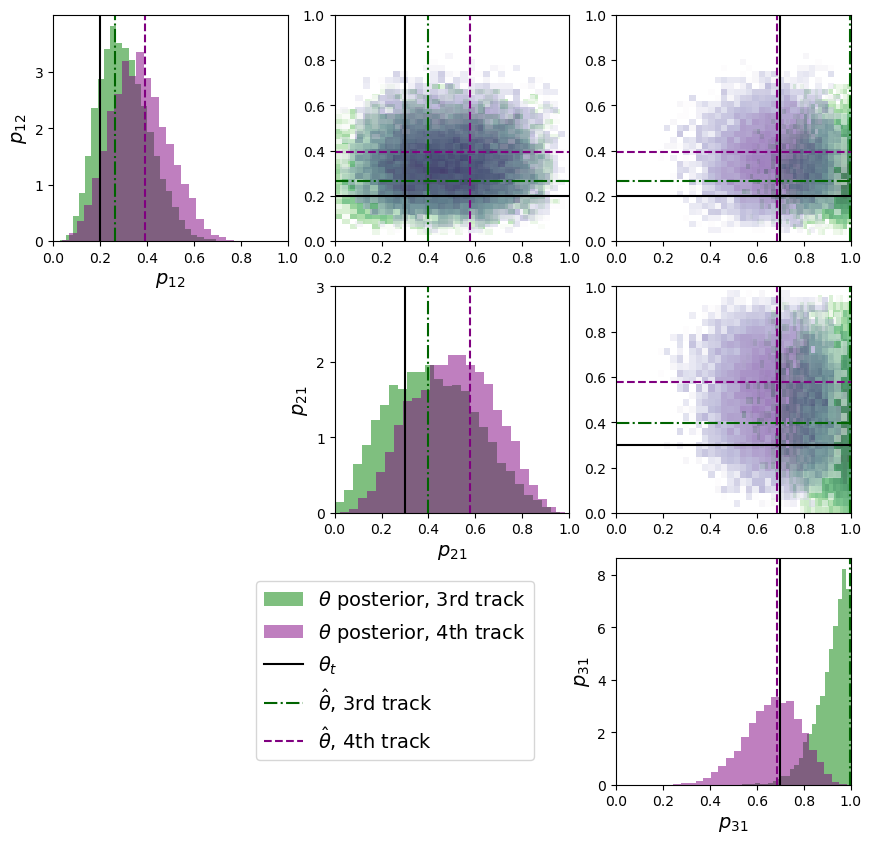

In [8]:
#Figure 4 panel B
fig, ax = plt.subplots(3, 3, figsize=(3*2+5,3*2+4))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(3):
    ax[i,i].set_ylabel(parameter_names_tex[i+5], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i+5], fontsize=14)
    
priors = [[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0], [-4.0, 4.0],
          [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 2.0*sigma]]

for i in range(3):
    ax[i,i].hist(theta_all['120_3rd'][i+5,:], bins=25, alpha=0.5, density=True,
                 label=r'$\theta$ posterior, 3rd track', color='green')
    ax[i,i].hist(theta_all['120_4th'][i+5,:], bins=25, alpha=0.5, density=True,
                 label=r'$\theta$ posterior, 4th track', color='purple')
    if theta_true is not None:
        ax[i,i].axvline(theta_true[i+5], color='black',
                        label=r'$\theta_t$')
    if log_pi is not None:
        best_theta_comp_i = {}
        best_theta_comp_i['120_3rd'] = theta_all['120_3rd'][i+5, np.nanargmax(log_pi['120_3rd'])]
        ax[i,i].axvline(best_theta_comp_i['120_3rd'], linestyle='-.', color='darkgreen',
                        label=r'$\hat\theta$, 3rd track')
        best_theta_comp_i['120_4th'] = theta_all['120_4th'][i+5, np.nanargmax(log_pi['120_4th'])]
        ax[i,i].axvline(best_theta_comp_i['120_4th'], linestyle='--', color='purple',
                        label=r'$\hat\theta$, 4th track')
    ax[i,i].set_xlim(priors[i+5])
    if i==2:
        ax[i,i].set_yticks([0,2,4,6,8])
    else:
        ax[i,i].set_yticks([0,1,2,3])
for i in range(3):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,3):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all['120_3rd'][j+5,:], theta_all['120_3rd'][i+5,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='Greens')
        ax[i,j].hist2d(theta_all['120_4th'][j+5,:], theta_all['120_4th'][i+5,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.5, cmap='Purples')
        ax[i,j].set_xlim(priors[j+5])
        ax[i,j].set_ylim(priors[i+5])
        
        ax[i,j].axvline(theta_all['120_3rd'][j+5, np.nanargmax(log_pi['120_3rd'])], linestyle='-.', color='darkgreen')
        ax[i,j].axhline(theta_all['120_3rd'][i+5, np.nanargmax(log_pi['120_3rd'])], linestyle='-.', color='darkgreen')
        ax[i,j].axvline(theta_all['120_4th'][j+5, np.nanargmax(log_pi['120_4th'])], linestyle='--', color='purple')
        ax[i,j].axhline(theta_all['120_4th'][i+5, np.nanargmax(log_pi['120_4th'])], linestyle='--', color='purple')
        
        ax[i,j].axvline(theta_true[j+5], color='black')
        ax[i,j].axhline(theta_true[i+5], color='black')
plt.subplots_adjust(right=0.85)
plt.legend(bbox_to_anchor=(-0.35, 0.9), loc='upper right', borderaxespad=0, fontsize=14)
plt.savefig("compare_parameters_posteriors_with_prior_N=400_3rd_vs_4th_cut.png", format="png", dpi=1200, bbox_inches="tight")
plt.show()

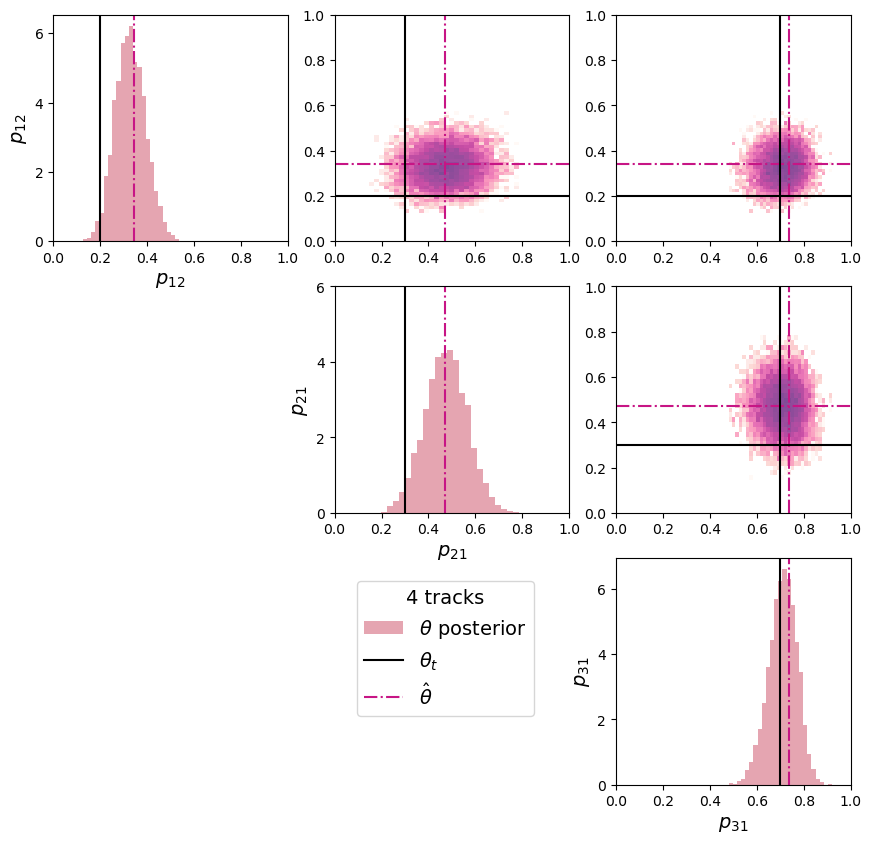

In [9]:
#Figure 4 panel D
fig, ax = plt.subplots(3, 3, figsize=(3*2+5,3*2+4))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(3):
    ax[i,i].set_ylabel(parameter_names_tex[i+5], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i+5], fontsize=14)
    
priors = [[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0], [-4.0, 4.0],
          [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 2.0*sigma]]

for i in range(3):
    ax[i,i].hist(theta_all['120_4'][i+5,:], bins=25, alpha=0.6, density=True,
                 label=r'$\theta$ posterior', color='#d46a7e')
    ax[i,i].axvline(theta_true[i+5], color='black',
                    label=r'$\theta_t$')
    best_theta_comp_i = {}
    best_theta_comp_i['120_4'] = theta_all['120_4'][i+5, np.nanargmax(log_pi['120_4'])]
    ax[i,i].axvline(best_theta_comp_i['120_4'], linestyle='-.', color='mediumvioletred',
                    label=r'$\hat\theta$')
    ax[i,i].set_xlim(priors[i+5])
    ax[i,i].set_yticks([0,2,4,6])
for i in range(3):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,3):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all['120_4'][j+5,:], theta_all['120_4'][i+5,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='RdPu')
        ax[i,j].set_xlim(priors[j+5])
        ax[i,j].set_ylim(priors[i+5])
        
        ax[i,j].axvline(theta_all['120_4'][j+5, np.nanargmax(log_pi['120_4'])], linestyle='-.', color='mediumvioletred')
        ax[i,j].axhline(theta_all['120_4'][i+5, np.nanargmax(log_pi['120_4'])], linestyle='-.', color='mediumvioletred')
        
        ax[i,j].axvline(theta_true[j+5], color='black')
        ax[i,j].axhline(theta_true[i+5], color='black')
plt.subplots_adjust(right=0.85)
plt.legend(title='4 tracks', title_fontsize=14, bbox_to_anchor=(-0.35, 0.9), loc='upper right', borderaxespad=0, fontsize=14)
plt.savefig("compare_parameters_posteriors_with_prior_N=400_4_cut.png", format="png", dpi=1200, bbox_inches="tight")
plt.show()

In [10]:
for j in range(3):
    print('\n',parameter_names[j+5])
    print(np.std(theta_all['120_1st'][j+5,:]))
    print(np.std(theta_all['120_2nd'][j+5,:]))
    print(np.std(theta_all['120_3rd'][j+5,:]))
    print(np.std(theta_all['120_4th'][j+5,:]))
    print(np.std(theta_all['120_4'][j+5,:]))


 p12
0.12919286603541127
0.10351993805496129
0.10674553187744387
0.12113811700113583
0.06446314093974784

 p21
0.13793254114667133
0.1581958411000813
0.1872654513338973
0.17271153024818567
0.09054302623277838

 p31
0.12512858661239976
0.11124506213024406
0.06909342033431452
0.11880296077601982
0.06044106505579099


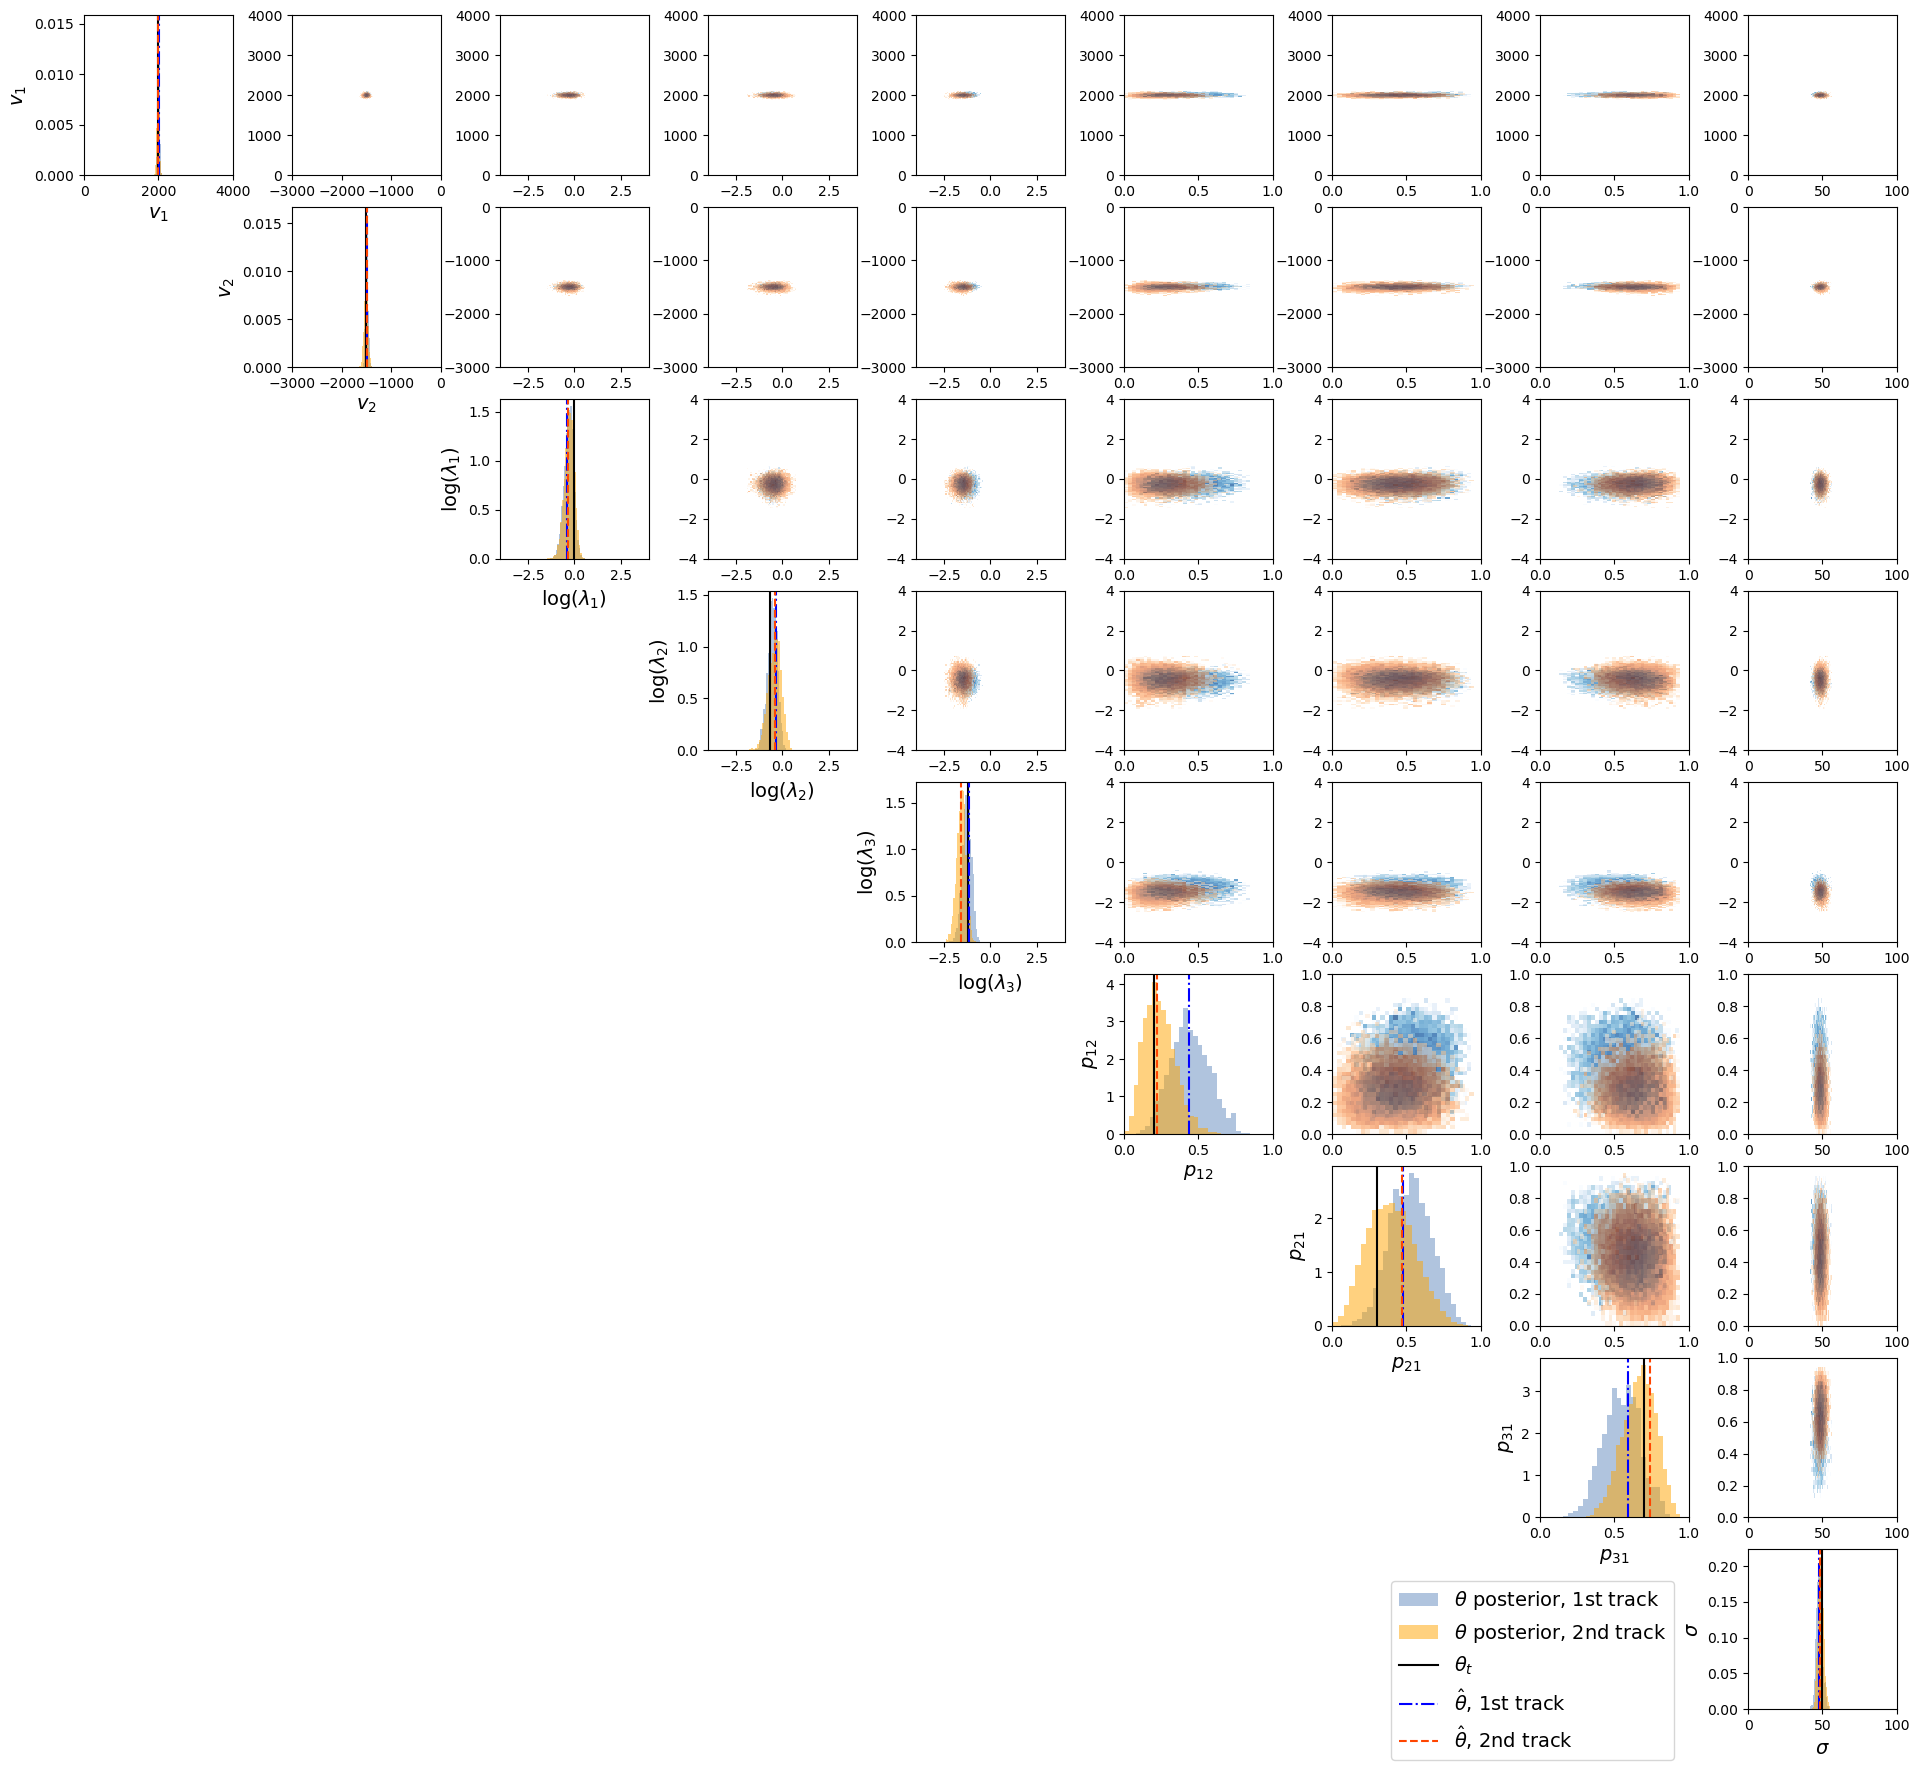

In [18]:
#Supplementary Figure S7
fig, ax = plt.subplots(n_param, n_param, figsize=(n_param*2+5+2,n_param*2+2+2))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
for i in range(n_param):
    ax[i,i].set_ylabel(parameter_names_tex[i], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i], fontsize=14)
    
priors = [[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0], [-4.0, 4.0],
          [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 2.0*sigma]]

for i in range(n_param):
    ax[i,i].hist(theta_all['120_1st'][i,:], bins=25, alpha=1.0, density=True,
                 label=r'$\theta$ posterior, 1st track', color='lightsteelblue')
    ax[i,i].hist(theta_all['120_2nd'][i,:], bins=25, alpha=0.5, density=True,
                 label=r'$\theta$ posterior, 2nd track', color='orange')
    if theta_true is not None:
        ax[i,i].axvline(theta_true[i], color='black',
                        label=r'$\theta_t$')
    if log_pi is not None:
        best_theta_comp_i = {}
        best_theta_comp_i['120_1st'] = theta_all['120_1st'][i, np.nanargmax(log_pi['120_1st'])]
        ax[i,i].axvline(best_theta_comp_i['120_1st'], linestyle='-.', color='blue',
                        label=r'$\hat\theta$, 1st track')
        best_theta_comp_i['120_2nd'] = theta_all['120_2nd'][i, np.nanargmax(log_pi['120_2nd'])]
        ax[i,i].axvline(best_theta_comp_i['120_2nd'], linestyle='--', color='orangered',
                        label=r'$\hat\theta$, 2nd track')
    ax[i,i].set_xlim(priors[i])
for i in range(n_param):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,n_param):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all['120_1st'][j,:], theta_all['120_1st'][i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='Blues')
        ax[i,j].hist2d(theta_all['120_2nd'][j,:], theta_all['120_2nd'][i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.5, cmap='Oranges')
        ax[i,j].set_xlim(priors[j])
        ax[i,j].set_ylim(priors[i])
        
        #ax[i,j].axvline(theta_all['120_1st'][j, np.nanargmax(log_pi['120_1st'])], linestyle='-.', color='blue')
        #ax[i,j].axhline(theta_all['120_1st'][i, np.nanargmax(log_pi['120_1st'])], linestyle='-.', color='blue')
        #ax[i,j].axvline(theta_all['120_2nd'][j, np.nanargmax(log_pi['120_2nd'])], linestyle='--', color='orangered')
        #ax[i,j].axhline(theta_all['120_2nd'][i, np.nanargmax(log_pi['120_2nd'])], linestyle='--', color='orangered')
        
        #ax[i,j].axvline(theta_true[j], color='black')
        #ax[i,j].axhline(theta_true[i], color='black')
plt.subplots_adjust(right=0.85)
plt.legend(bbox_to_anchor=(-0.5, 0.8), loc='upper right', borderaxespad=0, fontsize=14)
plt.savefig("Figure_4SI_S7_compare_parameters_posteriors_with_prior_N=400_1st_vs_2nd.png", format="png", dpi=400, bbox_inches="tight")
plt.show()

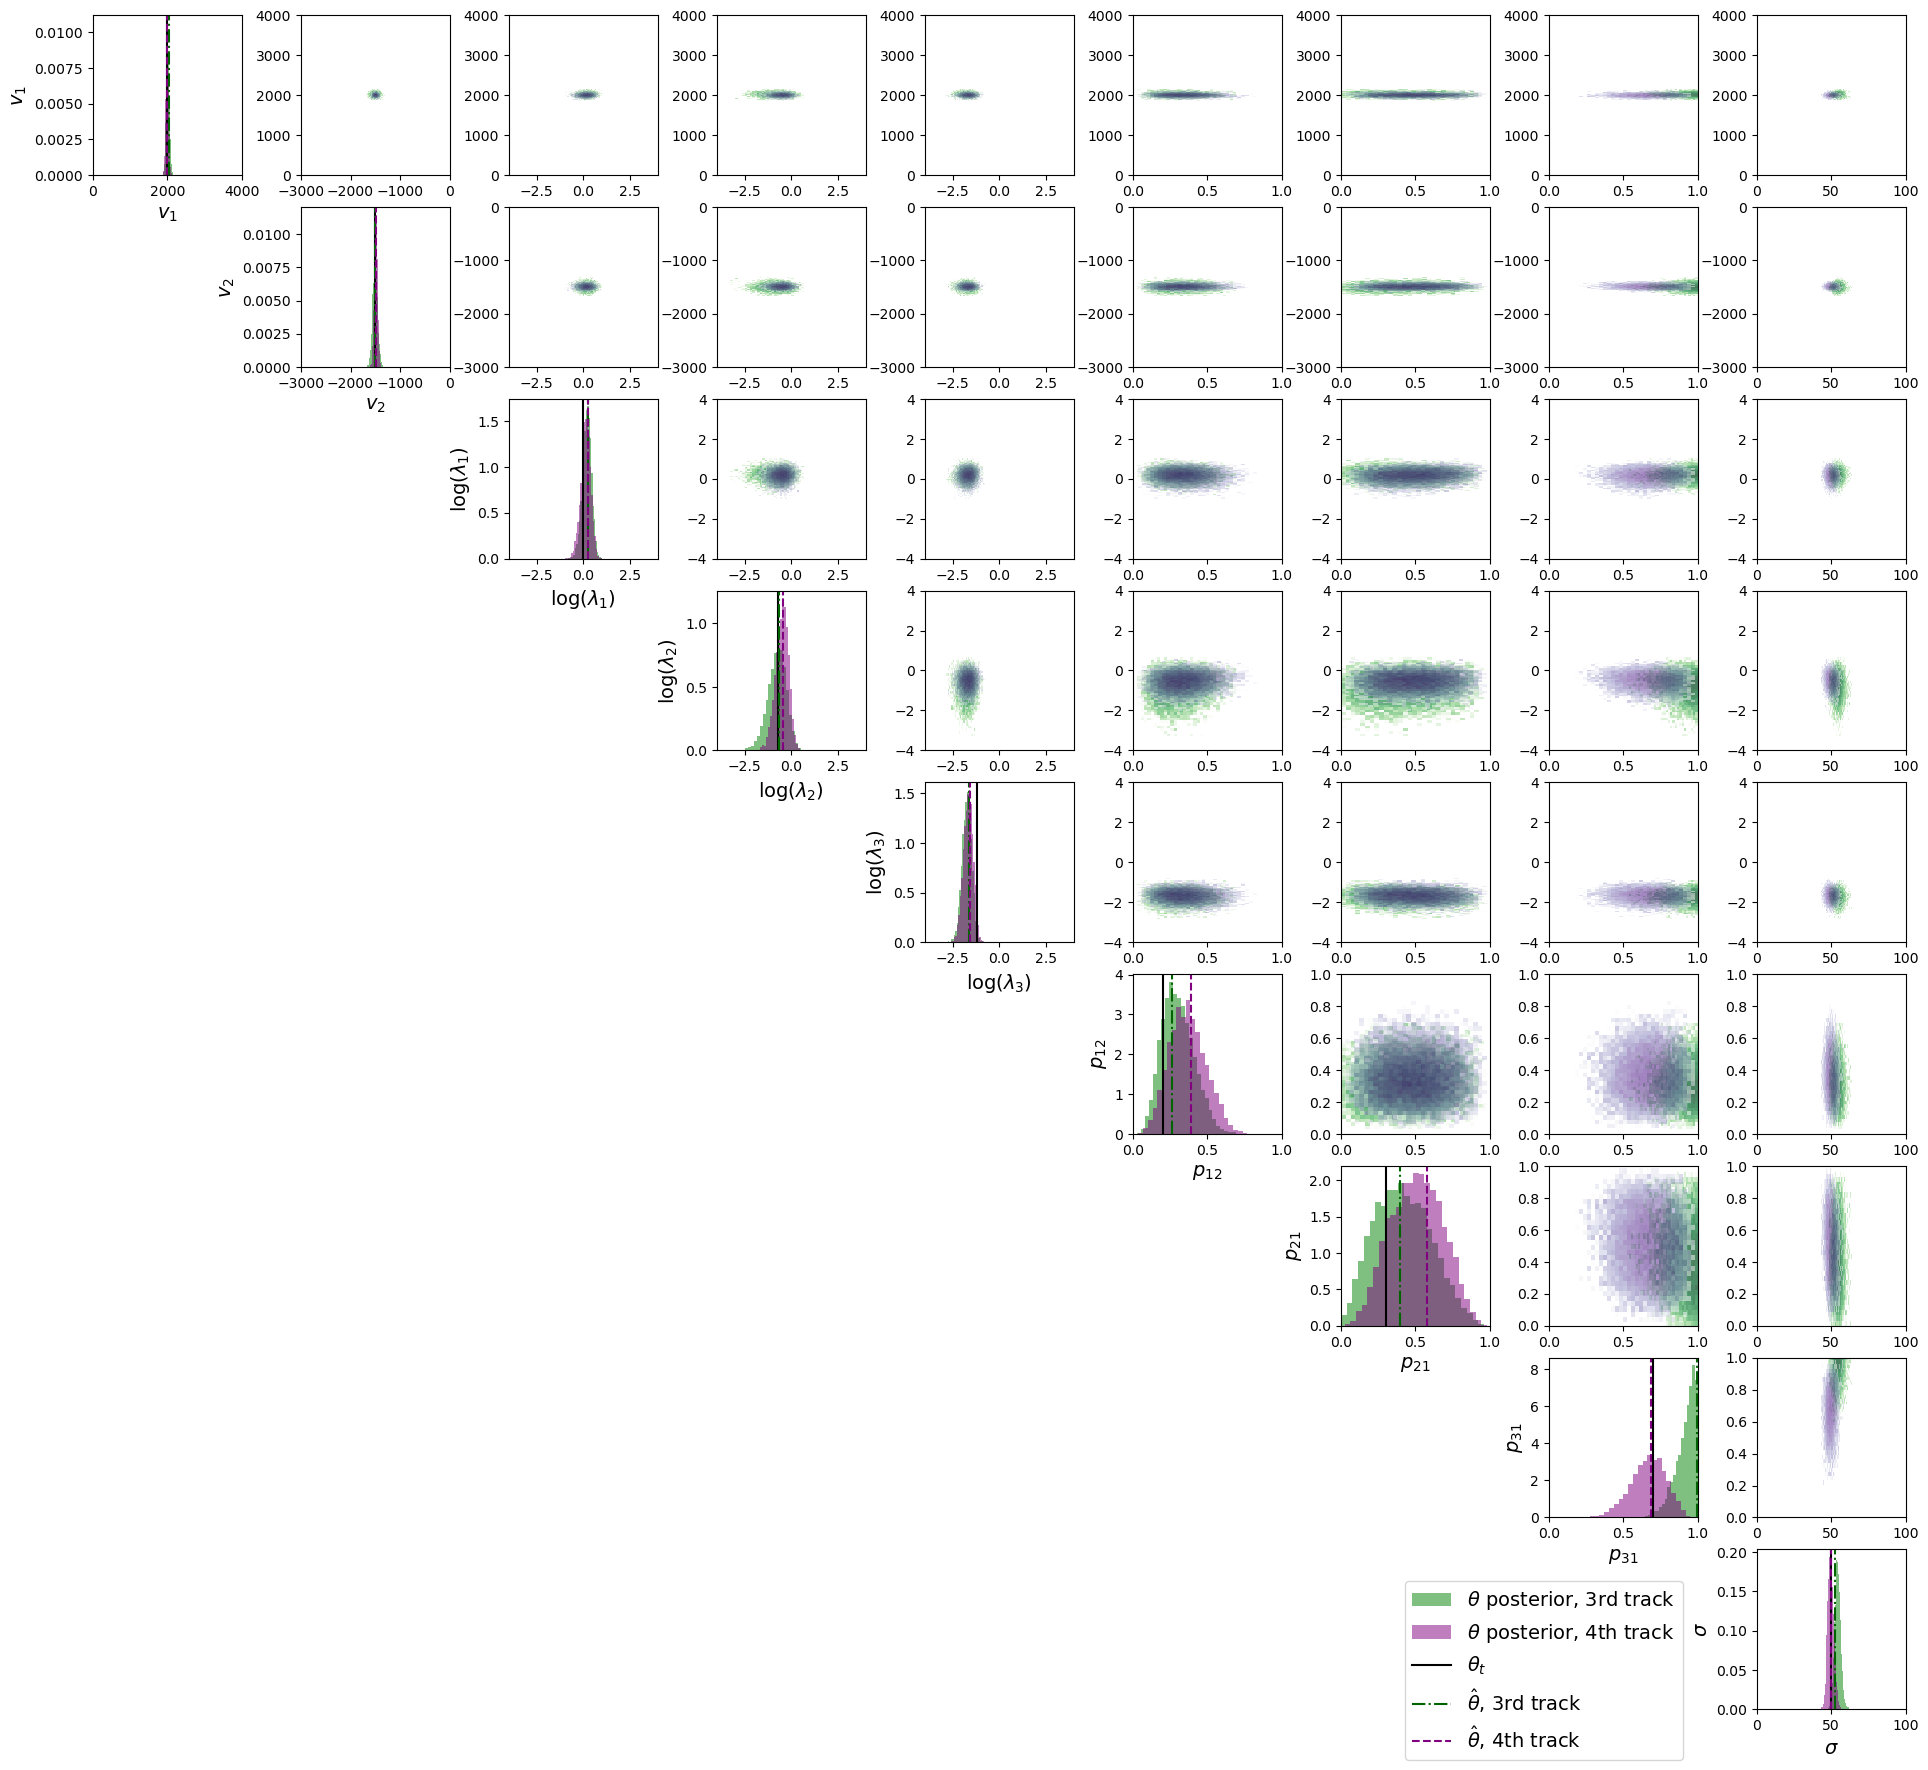

In [19]:
#Supplementary Figure S8
fig, ax = plt.subplots(n_param, n_param, figsize=(n_param*2+5+2,n_param*2+2+2))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
for i in range(n_param):
    ax[i,i].set_ylabel(parameter_names_tex[i], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i], fontsize=14)
    
priors = [[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0], [-4.0, 4.0],
          [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 2.0*sigma]]

for i in range(n_param):
    ax[i,i].hist(theta_all['120_3rd'][i,:], bins=25, alpha=0.5, density=True,
                 label=r'$\theta$ posterior, 3rd track', color='green')
    ax[i,i].hist(theta_all['120_4th'][i,:], bins=25, alpha=0.5, density=True,
                 label=r'$\theta$ posterior, 4th track', color='purple')
    if theta_true is not None:
        ax[i,i].axvline(theta_true[i], color='black',
                        label=r'$\theta_t$')
    if log_pi is not None:
        best_theta_comp_i = {}
        best_theta_comp_i['120_3rd'] = theta_all['120_3rd'][i, np.nanargmax(log_pi['120_3rd'])]
        ax[i,i].axvline(best_theta_comp_i['120_3rd'], linestyle='-.', color='darkgreen',
                        label=r'$\hat\theta$, 3rd track')
        best_theta_comp_i['120_4th'] = theta_all['120_4th'][i, np.nanargmax(log_pi['120_4th'])]
        ax[i,i].axvline(best_theta_comp_i['120_4th'], linestyle='--', color='purple',
                        label=r'$\hat\theta$, 4th track')
    ax[i,i].set_xlim(priors[i])
for i in range(n_param):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,n_param):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all['120_3rd'][j,:], theta_all['120_3rd'][i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='Greens')
        ax[i,j].hist2d(theta_all['120_4th'][j,:], theta_all['120_4th'][i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.5, cmap='Purples')
        ax[i,j].set_xlim(priors[j])
        ax[i,j].set_ylim(priors[i])
        
        #ax[i,j].axvline(theta_all['120_3rd'][j, np.nanargmax(log_pi['120_3rd'])], linestyle='-.', color='blue')
        #ax[i,j].axhline(theta_all['120_3rd'][i, np.nanargmax(log_pi['120_3rd'])], linestyle='-.', color='blue')
        #ax[i,j].axvline(theta_all['120_4th'][j, np.nanargmax(log_pi['120_4th'])], linestyle='--', color='orangered')
        #ax[i,j].axhline(theta_all['120_4th'][i, np.nanargmax(log_pi['120_4th'])], linestyle='--', color='orangered')
        
        #ax[i,j].axvline(theta_true[j], color='black')
        #ax[i,j].axhline(theta_true[i], color='black')
plt.subplots_adjust(right=0.85)
plt.legend(bbox_to_anchor=(-0.5, 0.8), loc='upper right', borderaxespad=0, fontsize=14)
plt.savefig("Figure_4SI_S8_compare_parameters_posteriors_with_prior_N=400_3rd_vs_4th.png", format="png", dpi=400, bbox_inches="tight")
plt.show()

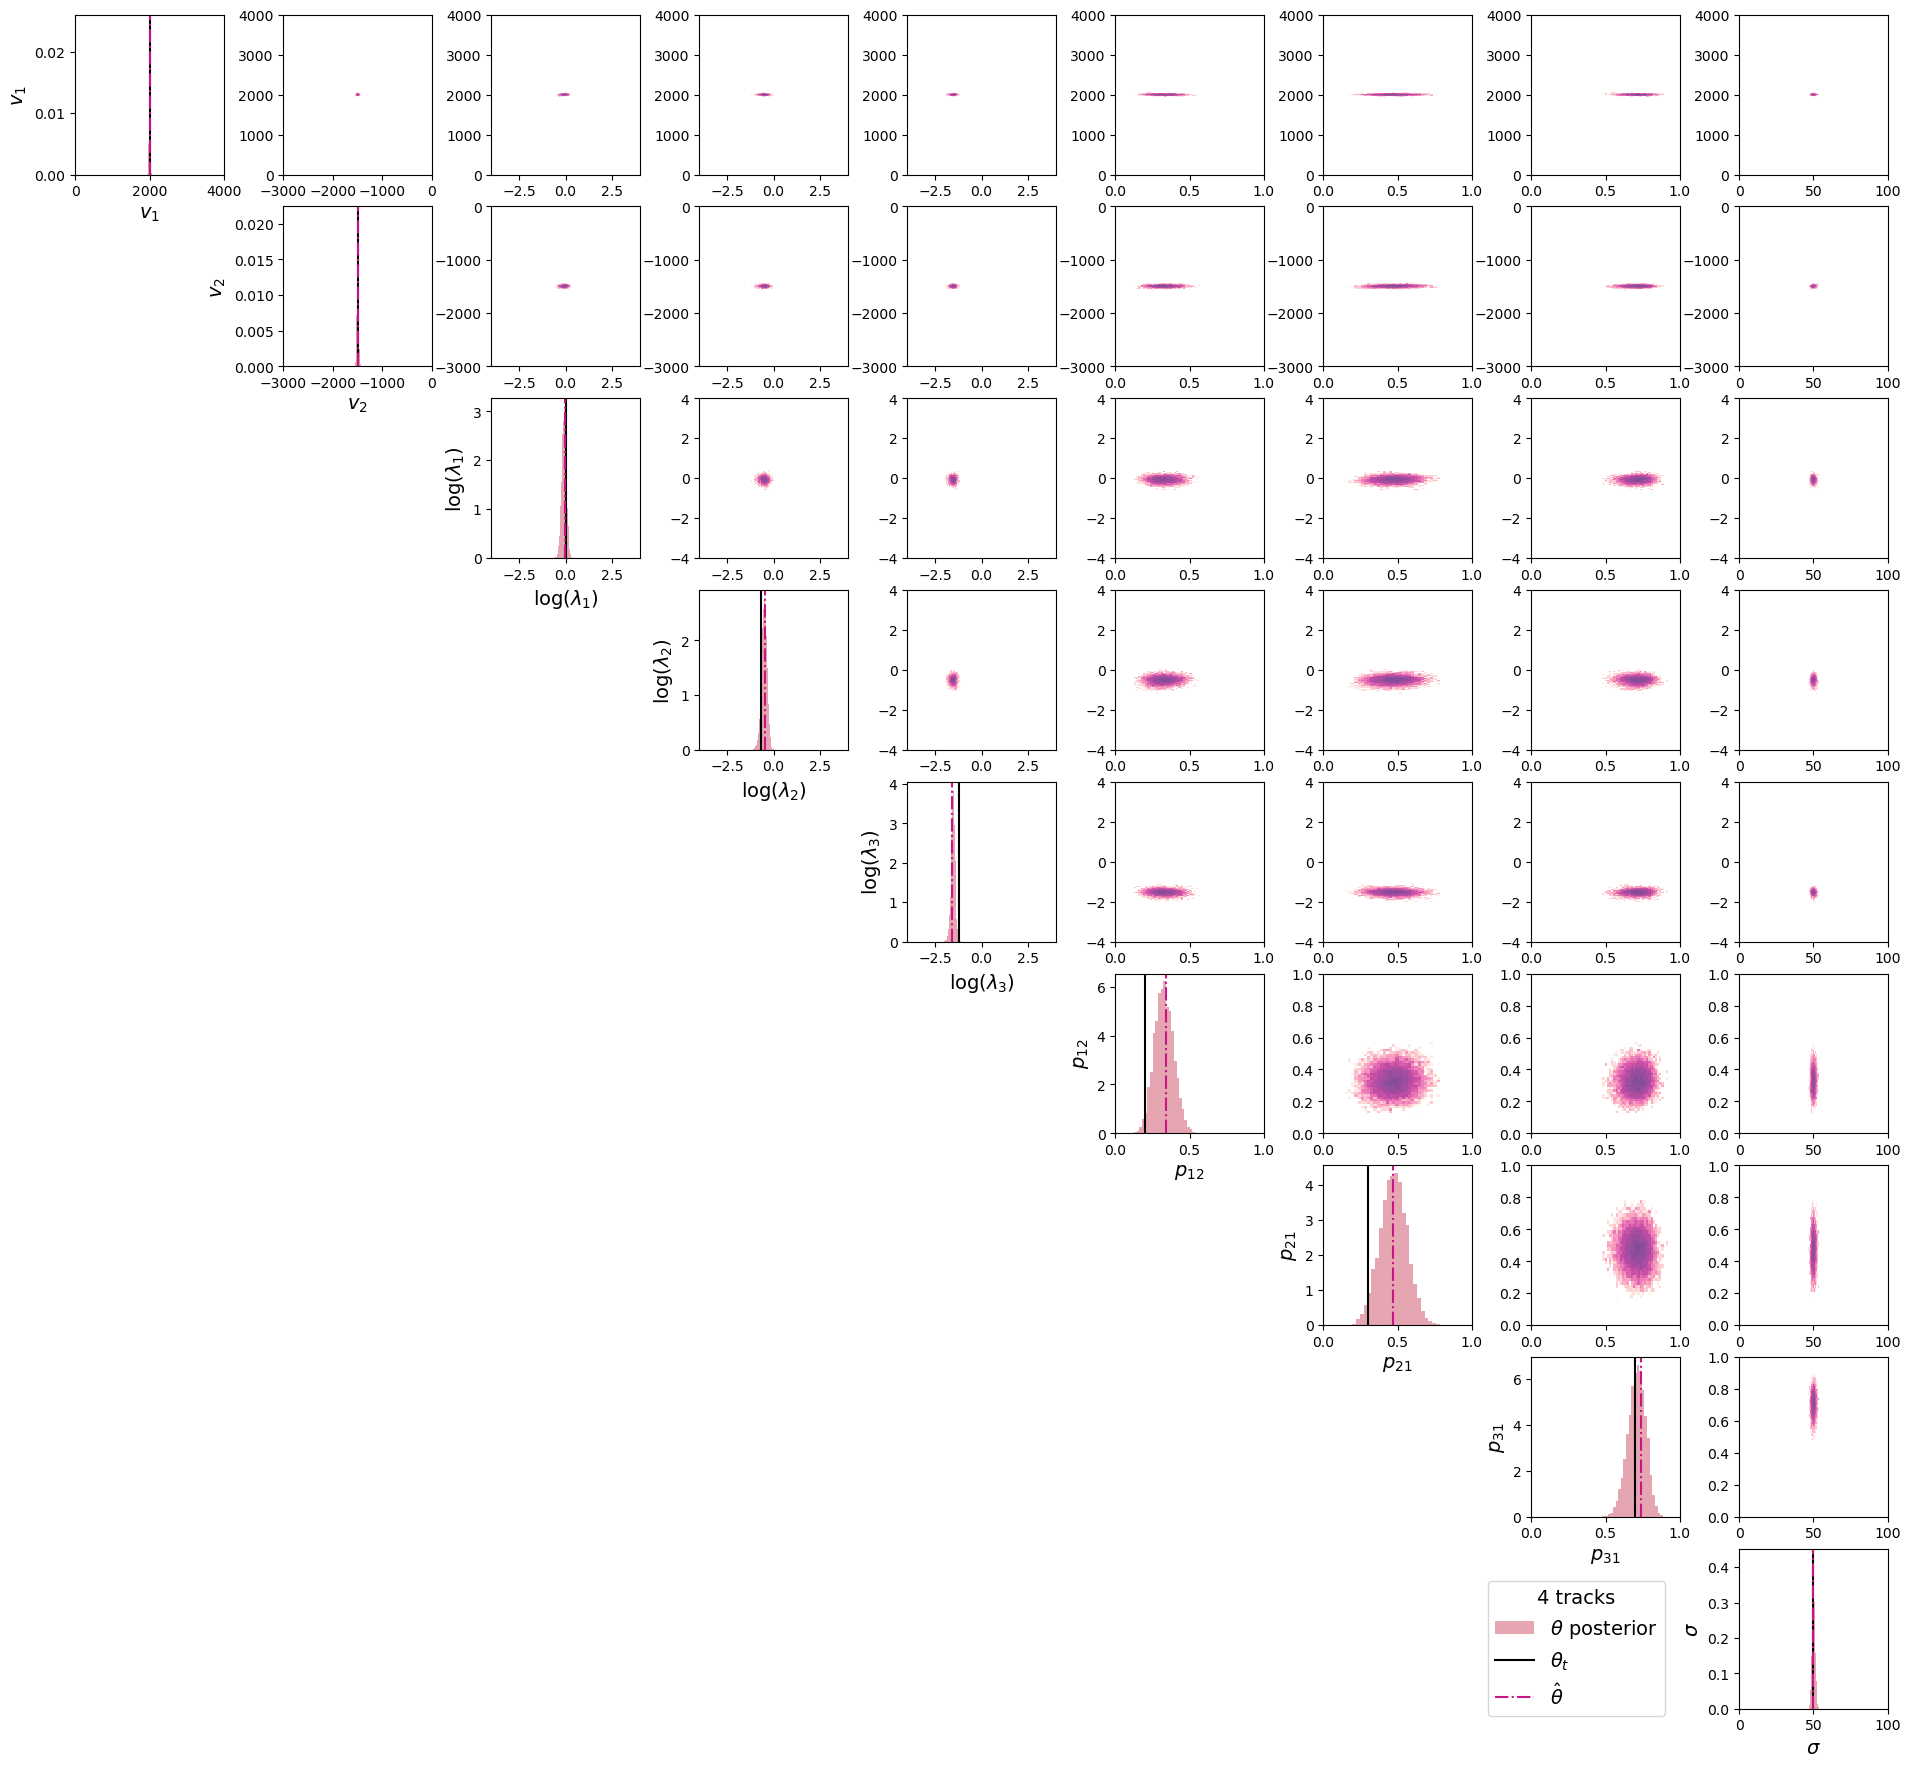

In [20]:
#Supplementary Figure S9
fig, ax = plt.subplots(n_param, n_param, figsize=(n_param*2+5+2,n_param*2+2+2))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
for i in range(n_param):
    ax[i,i].set_ylabel(parameter_names_tex[i], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i], fontsize=14)
    
priors = [[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0], [-4.0, 4.0],
          [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 2.0*sigma]]

for i in range(n_param):
    ax[i,i].hist(theta_all['120_4'][i,:], bins=25, alpha=0.6, density=True,
                 label=r'$\theta$ posterior', color='#d46a7e')
    ax[i,i].axvline(theta_true[i], color='black',
                    label=r'$\theta_t$')
    best_theta_comp_i = {}
    best_theta_comp_i['120_4'] = theta_all['120_4'][i, np.nanargmax(log_pi['120_4'])]
    ax[i,i].axvline(best_theta_comp_i['120_4'], linestyle='-.', color='mediumvioletred',
                    label=r'$\hat\theta$')
    ax[i,i].set_xlim(priors[i])
for i in range(n_param):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,n_param):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all['120_4'][j,:], theta_all['120_4'][i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='RdPu')
        ax[i,j].set_xlim(priors[j])
        ax[i,j].set_ylim(priors[i])
        
        #ax[i,j].axvline(theta_all['120_4'][j, np.nanargmax(log_pi['120_4'])], linestyle='-.', color='indigo')
        #ax[i,j].axhline(theta_all['120_4'][i, np.nanargmax(log_pi['120_4'])], linestyle='-.', color='indigo')
        
        #ax[i,j].axvline(theta_true[j], color='black')
        #ax[i,j].axhline(theta_true[i], color='black')
plt.subplots_adjust(right=0.85)
plt.legend(title='4 tracks', title_fontsize=14, bbox_to_anchor=(-0.5, 0.8), loc='upper right', borderaxespad=0, fontsize=14)
plt.savefig("Figure_4SI_S9_compare_parameters_posteriors_with_prior_N=400_4.png", format="png", dpi=400, bbox_inches="tight")
plt.show()

In [14]:
def get_parameters(theta):
    """Obtaining parameters from theta"""
    V = np.array(list(theta[0:2])+[0.0])
    Lambda = np.exp(theta[2:5])
    P = np.array([[0.0, theta[-4], 1.0-theta[-4]],
                  [theta[-3], 0.0, 1.0-theta[-3]],
                  [theta[-2], 1-theta[-2], 0.0]])
    sigma = 1.0*theta[-1]
    #print(V, Lambda, P, sigma)
    return V, Lambda, P, sigma

In [15]:
#120 1st
V, Lambda, P, sigma = get_parameters(theta_true)
output_2nd = n_state_model(0.3, 120, V, Lambda, P, sigma, seed=3001+4999*0+5099*0)
#120 2nd
V, Lambda, P, sigma = get_parameters(theta_true)
output_1st = n_state_model(0.3, 120, V, Lambda, P, sigma, seed=3001+4999*0+5099*1)
#120 3rd
V, Lambda, P, sigma = get_parameters(theta_true)
output_3rd = n_state_model(0.3, 120, V, Lambda, P, sigma, seed=3001+4999*0+5099*2)
#120 4th
V, Lambda, P, sigma = get_parameters(theta_true)
output_4th = n_state_model(0.3, 120, V, Lambda, P, sigma, seed=3001+4999*0+5099*3)

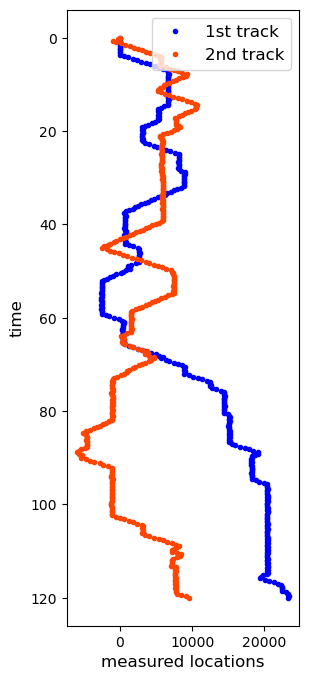

In [16]:
#Figure 4 panel C left
N = 400
plt.figure(figsize=(3,8))
plt.plot(output_1st[1],delta_t*np.arange(0,N+1), '.', color='blue', alpha=1, label=r'1st track')
plt.plot(output_2nd[1],delta_t*np.arange(0,N+1), '.', color='orangered', alpha=1, label=r'2nd track')
plt.xlabel(r'measured locations', fontsize=12)
plt.ylabel(r'time', fontsize=12)
plt.gca().invert_yaxis()
plt.legend(fontsize=12, loc='upper right')
plt.savefig('y_plot_tracks_1st_2nd.png', format="png", dpi=1200, bbox_inches="tight")
plt.show()

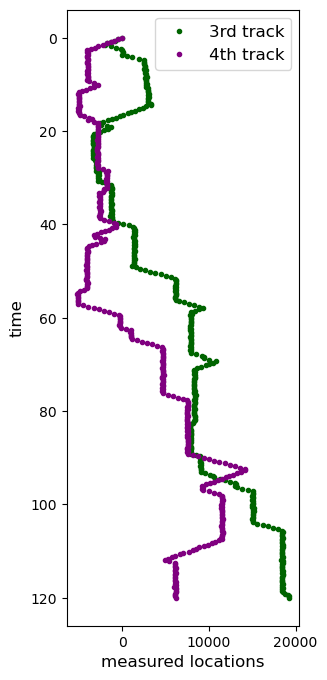

In [17]:
#Figure 4 panel C right
N = 400
plt.figure(figsize=(3,8))
plt.plot(output_3rd[1],delta_t*np.arange(0,N+1), '.', color='darkgreen', alpha=1, label=r'3rd track')
plt.plot(output_4th[1],delta_t*np.arange(0,N+1), '.', color='purple', alpha=1, label=r'4th track')
plt.xlabel(r'measured locations', fontsize=12)
plt.ylabel(r'time', fontsize=12)
plt.gca().invert_yaxis()
plt.legend(fontsize=12)
plt.savefig('y_plot_tracks_3rd_4th.png', format="png", dpi=1200, bbox_inches="tight")
plt.show()